# Event manager

The event manager is the system which manage the different behavior of a simulation. It is composed of two lists :
- `current` : list of actions to be executed during the current simulation step.
- `next`    : list of actions to be executed for the next simulation step, this list is filled during the current simulation step.


A behavior is a function which describes/contains the actions requested to realize an event. For example, the behavior which describe the cell division is composed of :
- growing cell area until its reach a certain threshold
- dividing cell into two daughter cell
 

![Event manager principle](illus/EventManager.png)


In [1]:
# Generate 2D tyssue

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import ipywidgets as widgets
from IPython import display
import ipyvolume as ipv

# Core object
from tyssue import Sheet
# Simple 2D geometry
from tyssue import PlanarGeometry as sgeom
# Visualisation
from tyssue.draw import (
    sheet_view,
    highlight_faces,
    create_gif,
    browse_history
)

sheet = Sheet.planar_sheet_2d(
    'basic2D', # a name or identifier for this sheet
    nx=6, # approximate number of cells on the x axis
    ny=7, # approximate number of cells along the y axis
    distx=1, # distance between 2 cells along x
    disty=1, # distance between 2 cells along y
    noise=0 # some position noise
)
sgeom.update_all(sheet)

# Give the tissue a nice hear cut ;)
sheet.sanitize(trim_borders=True, order_edges=True)
sgeom.update_all(sheet)

/home/admin-suz/miniconda3/lib/python3.8/site-packages/vispy/visuals/line/line.py:389: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _agg_vtype = np.dtype([('a_position', np.float32, 2),
/home/admin-suz/miniconda3/lib/python3.8/site-packages/vispy/visuals/line/arrow.py:52: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _arrow_vtype = np.dtype([
/home/admin-suz/miniconda3/lib/python3.8/site-packages/vispy/visuals/isocurve.py:22: UserWarning: VisPy is not yet compatible with matplotlib 2.2+
  warnings.warn("VisPy is not yet compatible with matplotlib 2.2+")


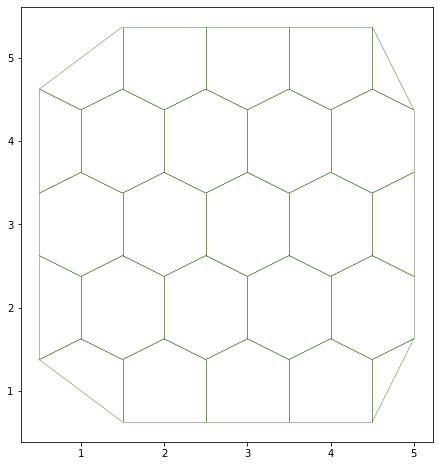

In [2]:
# Visualisation of the tissue
fig, ax = sheet_view(sheet, mode="2D")
fig.set_size_inches(8, 8)

In [3]:
from tyssue.dynamics.planar_vertex_model import PlanarModel as smodel
from tyssue.solvers import QSSolver
from pprint import pprint

specs = {
    'edge': {
        'is_active': 1,
        'line_tension': 0.12,
        'ux': 0.0,
        'uy': 0.0,
        'uz': 0.0
    },
   'face': {
       'area_elasticity': 1.0,
       'contractility': 0.04,
       'is_alive': 1,
       'prefered_area': 1.0},
   'settings': {
       'grad_norm_factor': 1.0,
       'nrj_norm_factor': 1.0
   },
   'vert': {
       'is_active': 1
   }
}


# Update the specs (adds / changes the values in the dataframes' columns)
sheet.update_specs(specs)


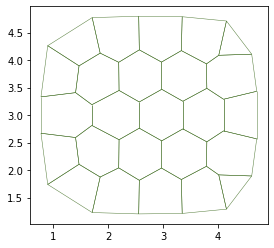

In [4]:
# Check the tissue is at its equilibrium
solver = QSSolver()
res = solver.find_energy_min(sheet, sgeom, smodel)
# Visualisation of the tissue
fig, ax = sheet_view(sheet, mode="2D")


## Write a behavior function

Behavior parameters function are composed of two parts :
- signature part, which contains `sheet` and `manager` parameter
- keywords part, which is specific to one behavior function


To add a behavior to the manager, `append` method has to be used, and it need as parameter the function name and the keyword part. 

In [5]:
from tyssue.topology.sheet_topology import cell_division

def division(sheet, manager, cell_id=0, crit_area=2.0, growth_rate=0.1, dt=1.):
    """Defines a division behavior.
    
    Parameters
    ----------
    
    sheet: a :class:`Sheet` object
    cell_id: int
        the index of the dividing cell
    crit_area: float
        the area at which 
    growth_rate: float
        increase in the prefered are per unit time
        A_0(t + dt) = A0(t) * (1 + growth_rate * dt)
    """

    
    if sheet.face_df.loc[cell_id, "area"] > crit_area:
        # restore prefered_area
        sheet.face_df.loc[12, "prefered_area"] = 1.0
        # Do division
        daughter = cell_division(sheet, cell_id, sgeom)
        # Update the topology
        sheet.reset_index(order=True)
        # update geometry
        sgeom.update_all(sheet)
        print(f"cell n°{daughter} is born")
    else:
        # 
        sheet.face_df.loc[12, "prefered_area"] *= (1 + dt * growth_rate)
        manager.append(division, cell_id=cell_id)

When the manager is initialised, `wait` function is aded by default in the `current` event list. Any new event added to the manager are added to the `next` list. 

In [6]:
from tyssue.behaviors import EventManager

# Initialisation of manager 
manager = EventManager("face")

# Add action/event to the manager
manager.append(division, cell_id=12)


In [7]:
print('manager.current :')
print(manager.current)
print()
print('manager.next :')
print(manager.next)

manager.current :
deque([(<function wait at 0x7f5692f084c0>, {'face_id': -1, 'n_steps': 1})])

manager.next :
deque([(<function division at 0x7f568421ed30>, {'cell_id': 12})])


In [8]:
from tyssue import History

t = 0
stop = 30

# The History object records all the time steps 
history = History(sheet)

while manager.current and t < stop:
    # Execute the event in the current list
    manager.execute(sheet)
    t += 1
    sheet.reset_index(order=True)
    # Find energy min
    res = solver.find_energy_min(sheet, sgeom, smodel)
    history.record()
    # Switch event list from the next list to the current list
    manager.update()

cell n°25 is born


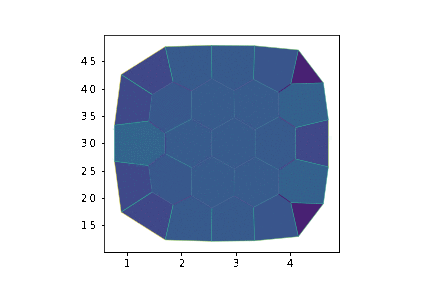

In [9]:
draw_specs = {
    "edge": {
        "color": lambda sheet: sheet.edge_df.length
    },
    "face": {
        "visible": True,
        "color": lambda sheet: sheet.face_df.area,
        "color_range": (0, 2)
    }
}

create_gif(history, "growth.gif", num_frames=30, margin=5, **draw_specs)
display.Image("growth.gif")

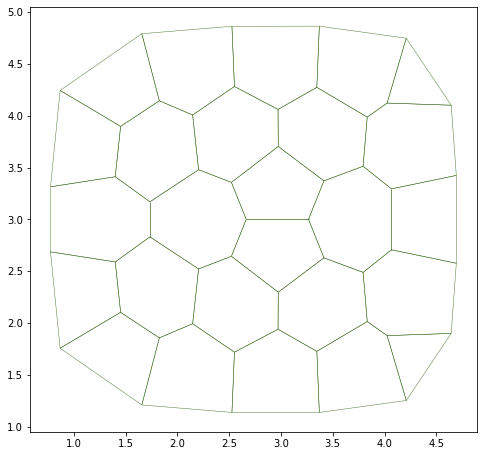

In [10]:
# Visualisation of the tissue
fig, ax = sheet_view(sheet, mode="2D")
fig.set_size_inches(8, 8)